In [31]:
import numpy as np
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Predict Rating (Biased model)

# $f = \alpha + \beta_{user} + \beta_{book}$

In [28]:
class Data_Processor():
    def __init__(self, filename, mode ='val'):
        '''
        Initialization
        '''
        self.data = pd.read_csv(filename)
        self.mode = mode
        self.usersPerBook = defaultdict(set)
        self.booksPerUser = defaultdict(set)
        self.alpha_init = 0 

        self.beta_user = {}
        self.beta_book = {}

        self.usersPerBook_rate = defaultdict(list)
        self.booksPerUser_rate = defaultdict(list)
        self.userbook_rating = {}
        
        if mode ==  'val':
            self.train_set = self.data[:190000]
            self.val_set = self.data[190000:]
        elif mode == 'test':
            self.train_set = self.data
            
        self.lamda = 0
            
    def preprocessing(self):
        '''
        Creater Dictionarys and Sets for the following tasks
        '''
        for i in self.train_set.values:
            user, book, rating = i
            self.usersPerBook[book].add(user)
            self.booksPerUser[user].add(book)

            self.usersPerBook_rate[book].append((user,rating))
            self.booksPerUser_rate[user].append((book,rating))

            self.userbook_rating[user+book] = rating
            self.alpha_init += rating
        self.alpha_init/=len(self.train_set)

    def model_initial(self):
        '''
        Initialize parameters of betas

        beta_user(dict): how often this user tends to rate higher than mean
        beta_book(dict): how often this item is rated higher than mean
        '''

        for u in self.booksPerUser:
            count_high = 0
            count = 0
            for b in self.booksPerUser_rate[u]:
                count+=1
                if b[1]>self.alpha_init:
                    count_high += 1
                else:
                    count_high -= 1

            self.beta_user[u] = float(count_high)/count

        for b in self.usersPerBook:
            count_high = 0
            count = 0
            for u in self.usersPerBook_rate[b]:
                count+=1
                if u[1]>self.alpha_init:
                    count_high += 1
                else:
                    count_high -= 1

            self.beta_book[b] = float(count_high)/count

    def optimized_lambda(self):
        '''
        Find Optimized lambda
        
        '''
        lamda = [i*0.5 for i in range(1,21)]
        MSE_lamda = []
        for lamb in lamda:

            old_MSE = 20
            MSE = 10
            
            beta_user = self.beta_user.copy()
            beta_book = self.beta_book.copy()
            
            alpha = self.alpha_init
            while MSE < old_MSE:
                old_MSE = MSE
                tmp_alpha = 0
                for i in self.train_set.values:
                    user, book, rating = i
                    # update alpha
                    tmp_alpha += (rating - (beta_user[user]+beta_book[book]))

                alpha = tmp_alpha /len(self.train_set)

                # update beta_user
                temp_beta_user={}
                for u in beta_user:
                    temp = sum([self.userbook_rating[u+b] - (alpha+beta_book[b]) for b in self.booksPerUser[u]])
                    temp_beta_user[u] = temp/ (lamb + len(self.booksPerUser[u]))

                # update beta_book
                temp_beta_book={}
                for b in beta_book:
                    temp = sum([self.userbook_rating[u+b] - (alpha+beta_user[u]) for u in self.usersPerBook[b]])
                    temp_beta_book[b] = temp/ (lamb + len(self.usersPerBook[b]))

                for u in beta_user:
                    beta_user[u] = temp_beta_user[u]
                for b in beta_book:
                    beta_book[b] = temp_beta_book[b]


                # calculate MSE(val)
                pred_r = []
                label_r = []
                error = 0
                for l in self.val_set.values:
                    u,b,r = l
                    label_r.append(r)
                    beta_u, beta_i = beta_user.get(u,0), beta_book.get(b,0)
                    pred = alpha + beta_u + beta_i
                    pred_r.append(pred)
                    error += (r - pred)**2
                MSE = error/len(pred_r)
            print('Lambda = %f - MSE = %f' %(lamb, MSE))
            MSE_lamda.append(MSE)
            
        index_lambda = min(range(len(MSE_lamda)), key=MSE_lamda.__getitem__)
        self.lamda = lamda[index_lambda]
        print('Minimum of MSE: %f at lambda = %.2f ' % (MSE_lamda[index_lambda], self.lamda))
        
        return self.lamda
    
        
    def train_model(self, lamb_input, n_epoch = 100):
        '''
        Train model with optimized lambda
        '''
        
        if self.lamda:
            lamb = self.lamda
            print('-----Start Training!!-----')
        else:
            lamb = lamb_input 
            print('-----Evaluate on Testing!!-----')
            
        for ite in range(n_epoch):
        
            tmp_alpha = 0
            for i in self.train_set.values:
                user, book, rating = i
                # update alpha
                tmp_alpha += (rating - (self.beta_user[user]+self.beta_book[book]))
            alpha = tmp_alpha /len(self.train_set)

            # update beta_user
            temp_beta_user={}
            for u in self.beta_user:
                temp = sum([self.userbook_rating[u+b] - (alpha+self.beta_book[b])\
                            for b in self.booksPerUser[u]])
                temp_beta_user[u] = temp/ (lamb + len(self.booksPerUser[u]))

            # update beta_book
            temp_beta_book={}
            for b in self.beta_book:
                temp = sum([self.userbook_rating[u+b] - (alpha+self.beta_user[u])\
                            for u in self.usersPerBook[b]])
                temp_beta_book[b] = temp/ (lamb + len(self.usersPerBook[b]))

            for u in self.beta_user:
                self.beta_user[u] = temp_beta_user[u]
            for b in self.beta_book:
                self.beta_book[b] = temp_beta_book[b]

                
            if self.mode == 'val':
                # calculate MSE(val)
                pred_r = []
                label_r = []
                error = 0
                for l in self.val_set.values:
                    u,b,r = l
                    label_r.append(r)
                    beta_u, beta_i = self.beta_user.get(u,0), self.beta_book.get(b,0)
                    pred = alpha + beta_u + beta_i
                    pred_r.append(pred)
                    error += (r - pred)**2
                MSE = error/len(pred_r)
                print('Iter: %f MSE = %f' % (ite,MSE))
            
            elif self.mode == 'test':
                self.pred_test = []
                with open("assignment1/predictions_Rating.txt", 'w') as predictions:
                    for l in open("assignment1/pairs_Rating.txt"):
                        if l.startswith("userID"):
                            #header
                            predictions.write(l)
                            continue

                        user,book = l.strip().split('-')
                        beta_u, beta_b = self.beta_user.get(user,0), self.beta_book.get(book,0)
                        pred = alpha + beta_u + beta_b
                        if pred>5:
                            pred = 5
                        elif pred<0:
                            pred = 0
                        self.pred_test.append(pred)

                        predictions.write(user + '-' + book + ',' + str(pred) + '\n')


In [19]:
filename = "assignment1/train_Interactions.csv.gz"
Rating_Predictor = Data_Processor(filename, mode = 'val')
Rating_Predictor.preprocessing()
Rating_Predictor.model_initial()
optimized_lambda = Rating_Predictor.optimized_lambda() # Tune parameters  𝜆

Lambda = 0.500000 - MSE = 1.122426
Lambda = 1.000000 - MSE = 1.115885
Lambda = 1.500000 - MSE = 1.112218
Lambda = 2.000000 - MSE = 1.109872
Lambda = 2.500000 - MSE = 1.108542
Lambda = 3.000000 - MSE = 1.108007
Lambda = 3.500000 - MSE = 1.108098
Lambda = 4.000000 - MSE = 1.108691
Lambda = 4.500000 - MSE = 1.109688
Lambda = 5.000000 - MSE = 1.111011
Lambda = 5.500000 - MSE = 1.112588
Lambda = 6.000000 - MSE = 1.114391
Lambda = 6.500000 - MSE = 1.116357
Lambda = 7.000000 - MSE = 1.118460
Lambda = 7.500000 - MSE = 1.120688
Lambda = 8.000000 - MSE = 1.122986
Lambda = 8.500000 - MSE = 1.125374
Lambda = 9.000000 - MSE = 1.127795
Lambda = 9.500000 - MSE = 1.130276
Lambda = 10.000000 - MSE = 1.132791
Minimum of MSE: 1.108007 at lambda = 3.00 


In [20]:
Rating_Predictor.train_model(100)

-----Start Training!!-----
Iter: 0.000000 MSE = 1.128488
Iter: 1.000000 MSE = 1.118908
Iter: 2.000000 MSE = 1.115590
Iter: 3.000000 MSE = 1.113445
Iter: 4.000000 MSE = 1.111976
Iter: 5.000000 MSE = 1.110870
Iter: 6.000000 MSE = 1.110125
Iter: 7.000000 MSE = 1.109527
Iter: 8.000000 MSE = 1.109128
Iter: 9.000000 MSE = 1.108803
Iter: 10.000000 MSE = 1.108586
Iter: 11.000000 MSE = 1.108410
Iter: 12.000000 MSE = 1.108293
Iter: 13.000000 MSE = 1.108200
Iter: 14.000000 MSE = 1.108138
Iter: 15.000000 MSE = 1.108090
Iter: 16.000000 MSE = 1.108059
Iter: 17.000000 MSE = 1.108036
Iter: 18.000000 MSE = 1.108022
Iter: 19.000000 MSE = 1.108013
Iter: 20.000000 MSE = 1.108008
Iter: 21.000000 MSE = 1.108005
Iter: 22.000000 MSE = 1.108005
Iter: 23.000000 MSE = 1.108007
Iter: 24.000000 MSE = 1.108009
Iter: 25.000000 MSE = 1.108011
Iter: 26.000000 MSE = 1.108015
Iter: 27.000000 MSE = 1.108018
Iter: 28.000000 MSE = 1.108021
Iter: 29.000000 MSE = 1.108025
Iter: 30.000000 MSE = 1.108028
Iter: 31.000000 MSE = 

# Testing

In [29]:
filename = "assignment1/train_Interactions.csv.gz"
Rating_Predictor = Data_Processor(filename, mode = 'test')
Rating_Predictor.preprocessing()
Rating_Predictor.model_initial()
Rating_Predictor.train_model(optimized_lambda, n_epoch = 100)

-----Evaluate on Testing!!-----


(array([  1.,   0.,   1.,   0.,   3.,   3.,  10.,  11.,  10.,  10.,   8.,
         11.,  12.,   6.,  14.,  10.,  10.,  17.,  15.,  15.,  18.,  14.,
         25.,  25.,  35.,  52.,  82.,  96., 119., 151., 185., 219., 283.,
        356., 456., 489., 553., 595., 652., 686., 685., 668., 627., 643.,
        543., 454., 370., 272., 203., 277.]),
 array([0.03315402, 0.13249094, 0.23182786, 0.33116478, 0.4305017 ,
        0.52983862, 0.62917554, 0.72851246, 0.82784938, 0.9271863 ,
        1.02652322, 1.12586014, 1.22519706, 1.32453398, 1.4238709 ,
        1.52320782, 1.62254474, 1.72188166, 1.82121857, 1.92055549,
        2.01989241, 2.11922933, 2.21856625, 2.31790317, 2.41724009,
        2.51657701, 2.61591393, 2.71525085, 2.81458777, 2.91392469,
        3.01326161, 3.11259853, 3.21193545, 3.31127237, 3.41060929,
        3.50994621, 3.60928313, 3.70862005, 3.80795697, 3.90729389,
        4.0066308 , 4.10596772, 4.20530464, 4.30464156, 4.40397848,
        4.5033154 , 4.60265232, 4.70198924, 4.

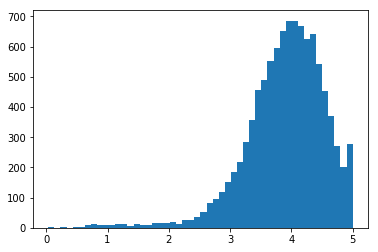

In [32]:
plt.figure()
plt.hist(Rating_Predictor.pred_test, 50)